In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tips = sns.load_dataset('tips').loc[:, ['total_bill', 'tip']]

pd.set_option('display.max_rows', 7)

# When is a Model a Good Model? (Prediction)

---

Unlike a model fit for inference, a predictive model need not reveal truths about the data generating process; it need only predict the values being generated.

The quality of a predictor is explained using the concepts of *bias* and *variance*. While, these terms relate to their statistical counterparts, they are used in a slightly different manner.

## Bias

A model with high bias gives systematically incorrect predictions and cannot capture the complexity of the data generating process.

**Definition:** The bias of a predictive model measures the average deviation of the predictions from the true values. The deviation is typically measured using the loss function over which the fit model was minimized. A model with high bias is said to *under-fit* the data.

Bias in a predictor is identified by the inability of the model to predict the data on which it was fit -- i.e. the loss function over which the fit model was minimized is large.

High bias, or under-fitting, is handled by adding complexity to the modeling pipeline. This may be done by:
1. Adding features to the model that captures the un-modeled complexity,
2. Using a different model type that is capable of capturing the un-modeled complexity.

**Example:** Consider the problem of predicting a restaurant tip amount from the total bill. A simple constant model ("every party tips exactly $3") is too simple to capture the trend between the variables. It suffers from high bias:

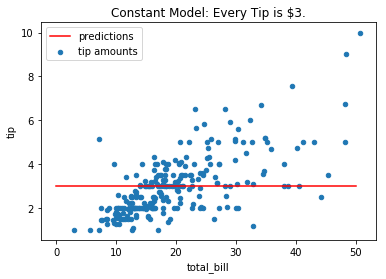

In [19]:
tips.plot(*tips.columns, kind='scatter', title='Constant Model: Every Tip is $3.')
plt.plot([0, 50], [3, 3], c='r');
plt.legend(['predictions', 'tip amounts']);

The RMSE of such a model is:

In [26]:
np.sqrt(np.mean((tips.tip - 3)**2)) # Bias

1.3808010267268185

Among all constant models, the one with the least bias is the one that always predicts the mean (prove this!) -- in this case ~$3. However, consider a more complex model type can decrease the bias: a constant percentage model more capably captures the relationship between the variables:

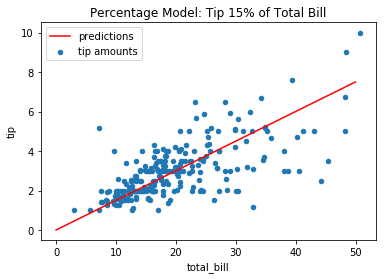

In [30]:
tips.plot(*tips.columns, kind='scatter', title='Percentage Model: Tip 15% of Total Bill')
plt.plot([0, 50], [0, 50 * 0.15], c='r');
plt.legend(['predictions', 'tip amounts']);

The RMSE of the 15% model is lower than the constant model:

In [32]:
preds = 0.15 * tips.total_bill
rmse = np.sqrt(np.mean((preds - tips.tip)**2))
rmse

1.0938913032845812

*Remark:* As seen in the previous section, the linear regression model fit to total bill and tip amount will be a better estimator than the 15% model!

## Variance

A model with high variance doesn't generalize well to new datasets. This is the case when a model has learned the observed data instead of the learning the data generating process.

**Definition:** For a specified model, the change in the parameters of the fit model as a function of new sample data, is the variance of the model. If the parameters of a model change significantly on out-of-sample data, then the model has high variance and is said to *over-fit* the data.

High variance in a predictor is identified by evaluating the bias of the model on new unseen data -- if the observed bias of the model significantly increases on new data, then the model is over-fit to the original sample.

High variance, or over-fitting, is handled by decreasing the complexity of the modeling pipeline.

**Example:** Fitting a polynomial model to the tips dataset, yields a predictor that likely "connects the dots" -- learning the training data, as opposed to a real relationship between the variables:

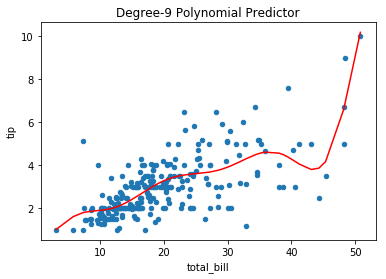

In [144]:
def func(x, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9):

    locs = locals()
    args = np.array(sorted([x for x in locs if 'a' == x[0]]))
    params = [locs[x] for x in args]    
    return np.sum(params * (x.values.reshape(-1, 1) ** np.arange(len(args))), axis=1)


from scipy import optimize
params, _ = optimize.curve_fit(func, tips.total_bill, tips.tip)

tips.plot(*tips.columns, kind='scatter', title='Degree-9 Polynomial Predictor')
plt.plot(tips.total_bill.sort_values(), func(tips.total_bill.sort_values(), *params), c='r');

Bootstrapping the data to simulate new draws from the same population illustrates the variation in the resulting fit polynomial models on the datasets. Notice, where data are sparse or outliers are present, the resulting predictors vary more:

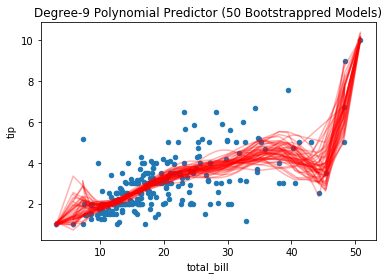

In [146]:
tips.plot(*tips.columns, kind='scatter', title='Degree-9 Polynomial Predictor (50 Bootstrappred Models)')
for _ in range(50):
    t = tips.sample(frac=1, replace=True)
    params, _ = optimize.curve_fit(func, t.total_bill, t.tip)
    plt.plot(t.total_bill.sort_values(), func(t.total_bill.sort_values(), *params), c='r', alpha=0.3);

Reducing the model complexity yields model parameters that vary less:

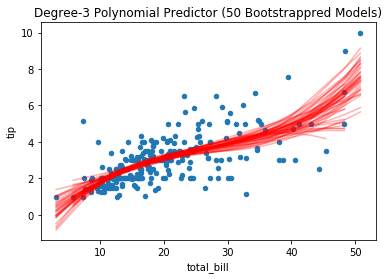

In [152]:
def func(x, a0, a1, a2, a3):

    locs = locals()
    args = np.array(sorted([x for x in locs if 'a' == x[0]]))
    params = [locs[x] for x in args]    
    return np.sum(params * (x.values.reshape(-1, 1) ** np.arange(len(args))), axis=1)


tips.plot(*tips.columns, kind='scatter', title='Degree-3 Polynomial Predictor (50 Bootstrappred Models)')
for _ in range(50):
    t = tips.sample(frac=1, replace=True)
    params, _ = optimize.curve_fit(func, t.total_bill, t.tip)
    plt.plot(t.total_bill.sort_values(), func(t.total_bill.sort_values(), *params), c='r', alpha=0.3);

## Bias-Variance Trade-off

In prediction problems, the concepts of bias and variance are in tension. This tension is known as the *bias-variance trade-off*, and can be quantified with the statistical notions of bias and variance.

In regression problems, the loss-function often being minimized is the (root)-mean-squared-error (MSE). This quantity can be decomposed into bias and variance, allowing one to understand the minimization of the loss-function in terms of these fundamental measures of model quality.

Suppose a data generating process takes on form of $y = f(x) + \epsilon$, where $x$ are independent variables, $f$ is the idealized process generating the data, and $\epsilon$ is a noise term (with mean $0$ and standard-deviation $\sigma^2$). A fit model $\hat f$ minimizes the square of the expected error (MSE):

$$\rm{MSE} = E[(y-\hat f(x))^2] = \rm{Bias}[\hat f(x)]^2 + \rm{Var}[\hat f(x)] + \sigma^2$$

Where the bias is given by $\rm{Bias}[\hat f(x)] = E[\hat f(x)] - E[y]$, and the variance is given by $\rm{Var}[\hat f] = E[\hat f(x)^2] - E[\hat f(x)]^2$. For a derivation of this decomposition see [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

Thus, the error being minimized decomposes into three non-negative terms:
* The square of the bias, driven by the errors in the ability to make predictions on the observed data.
* The variance captures the tendency for the predictions to deviate from their average. This quantity may be large, even if the (signed) errors are close on average.
* The irreducible error $\sigma^2$ represents the variation in the observed data from noise in the system. Such noise is unknowable; a perfect model will still have error equal to $\sigma^2$.

### The bias-variance possibilities

The bias-variance decomposition explain *how* model error presents itself and suggests ways to improve model performance. A model may exhibit varying combinations of bias and variance, under which the model may be explained:

* *Low-Bias / Low-Variance*: A good model that makes accurate prediction and captures the data generating process well.
* *High-Bias / Low-Variance:* A (under-fit) model that incorrectly predicts the events in a predictable way. This situation might occur from using a model pipeline that's too simple to describe the complex relationships in the data.
* *Low-Bias / High-Variance:* A (over-fit) model that memorizes the observed data without capturing the broader patterns of the data generating process.
* *High-Bias / High-Variance:* A model that is both over and under-fit to data. This might happen by choosing a very inappropriate model type, that over-fits on a subset of the observed data.

*Remark:* The observations above assume that the model is fit on a *representative sample*. Fitting a model on *bad data* might appear to create a very good low-bias, low-variance model, that is in fact a high-bias, low-variance model. This situation is especially dangerous, as it leads one to be very confident in a very bad model!

## Train-Test Split

In practice, how does one assess if a given model suffers from high bias or high variance?

* Bias is easily identified by looking at the error when fitting the model on observed data.
* Variance requires comparing the sensitivity of a model across datasets.

The assessment of the variance of a fit model can be done by reserving part of the observed data to act as this "other dataset" on which one can evaluate the fit model. This procedure is referred to as the *train-test split* of the data.

**Definition:** Given observed data on which a model is fit, a *train-test split* of the observed data is a random split of the dataset into two datasets (called 'training data' and 'test data') on which:
* the training data is used to fit the model, and
* the test data is used to evaluate the model.

A decrease in quality of a model between the training set (on which it was fit) and the test set likely means the model has high variance and *over-fit* the training data. 

### Train-test split in Scikit-Learn

In practice, the train-test split requires a number of choices. For example:
* How large should the test set be? The size of Train:Test is 3:1?
* How should the data be split? Uniformly? or in a more subtle way?

In general the larger the test set, the more reliable the estimate of performance on unseen data. However, too small of a training set might lead to higher bias in the model. Most commonly, the train-test split is done uniformly across observations, reserving a test set that is approximately 10-33% of the total data.

Scikit-learn has a function to do a train-test split an observed dataset $X, y$:

In [1]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

When building a model using a train-test split: 

* The training set is used to fit a model with the lowest possible bias,
* The test set gives an estimate of the fit models performance on unseen data.

It's important that the test set is *totally independent* from the training set.